---
<div align="center">
    
# S&P-500 | Stock Forecasting and Optimization
</div>

---

---
<div align="center">
    
## Problem Formulation [TO BE FIXED LATER]
</div>

---

### Context

The stock market is highly volatile and unpredictable which makes stock price forecasting and portfolio optimization challenging tasks. Therefore, since investors seek strategies that can provide risk-adjusted returns efficiently, this project aims to help them.

### Resolution Approach

This project focuses on using machine learning algorithms to forecast future stock prices of the S&P-500 Market Index and thereafter apply optimization methods to select the best set of stocks for daily investment. 

It combines data-driven forecasts with optimization techniques to maximize returns or minimize risks, creating a solution for real-world financial challenges.

### Planned Work

To properly develop this project, we have structured it along the following phases:
1. Data Preprocessing & Engineering
2. Data Cleaning
3. Exploratory Data Analysis - We aim to obtain greater insights on how the data 
4. Model Development and Evaluation - Use models like LSTMs, LGBM, Using proper training methodologies [Use a Window and simply move it N days further at each iteration and consider the new window as the training data of the model until we have reached the end of the data, aka, 2024 ]. Note: Always test with the 2024 data.
6. Portfolio Optimization - Using Monte Carlo, Min-Max and even genetic Algorithms
7. Results Analysis

---
<div align="center">
    
## Project Dependencies

</div>

---

In [1]:
# !pip install requests-cache requests-ratelimiter
# !pip install --upgrade yfinance

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# !pip install fbprophet
# !conda install -c anaconda ephem -y
# !conda install -c conda-forge pystan -y
# !conda install -c conda-forge fbprophet -y
# !pip install holidays==0.9.12

# !pip install pystan==2.19.1.1 prophet
# !pip install cmdstanpy==0.9.5

# !pip install fbprophet==0.6
# !pip install holidays==0.9.11

# !pip install lightgbm 

In [5]:
# Importing Dependencies
import numpy as np
import pandas as pd

# Import json to help save dictionaries into .json files
import json

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)

# Importing an API to handle the Datset from Yahoo Finance
import yfinance as yf
from yfinance import (Ticker)

# from fbprophet import Prophet
from lightgbm import (LGBMRegressor)

# Import a Sequential Model from tensorflow alongside the Adam Optimizer and layers
from tensorflow.keras.models import (Sequential)
from tensorflow.keras.optimizers import (Adam)
from tensorflow.keras import (layers)

from DataPreProcessing.DataExtraction import (extractSP500StocksInformationWikipedia, getSP500StockMarketInformation, getStockMarketInformation)
from DataPreProcessing.DataVisualization import (plotStockClosingPrice, plotFeatureDistribution)

from ModelDevelopmentAndEvaluation.StockPriceManager import (stockPriceManager)

from Utils.Configuration import (loadConfig, loadPathsConfig, loadInitialSetup)

# from pprint import pprint

In [23]:
# Load the configs
config = loadConfig()
pathsConfig = loadPathsConfig()
initialSetup = loadInitialSetup()
pathsConfig

{'ExploratoryDataAnalysis': './ExperimentalResults/',
 'Datasets': {'SP500-Stocks-Wikipedia': './Datasets/SP500-Stocks-Wikipedia.csv',
  'SP500-Market-Information': './Datasets/SP500-Market-Information.csv',
  'Stocks-Market-Information': './Datasets/Stocks/Raw',
  'Windowed-Stocks-Market-Information': './Datasets/Stocks/Windowed'},
 'ExperimentalResults': {}}

---
<div align="center">

## Data Preprocessing
</div>

---

---
### Exploratory Data Analysis
---

> ADD A DESCRIPTIVE ANALYSIS FOR THE EXPLORATORY DATA ANALYSIS

In [7]:
# dataset aquired @ https://www.nasdaq.com/market-activity/stocks/screener
# It consists of all the publicly available stocks globally
worldWideStocks = pd.read_csv('./Datasets/Stocks.csv')
worldWideStocks.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$139.65,2.780,2.031%,4.012531e+10,United States,1999.0,1795434,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$40.73,0.160,0.394%,1.052279e+10,United States,2016.0,2930997,Industrials,Aluminum
2,AACG,ATA Creativity Global American Depositary Shares,$1.04,0.030,2.97%,3.328014e+07,China,2008.0,64843,Real Estate,Other Consumer Services
3,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.87,-0.005,-0.046%,0.000000e+00,NaN,2023.0,26869,Finance,Blank Checks
4,AADI,Aadi Bioscience Inc. Common Stock,$1.96,-0.030,-1.508%,4.824508e+07,United States,NaN,24640,Health Care,Biotechnology: Pharmaceutical Preparations


In [8]:
# Extract some information of the S&P-500 Stocks from wikipedia
sp500Stocks = extractSP500StocksInformationWikipedia(pathsConfig)

# Compute the unique stocks
uniqueStocks = np.unique(sp500Stocks.Symbol.to_numpy())
print(f"There are {uniqueStocks.size} Unique Stocks out of {sp500Stocks.shape[0]} total Available Stocks on the S&P 500 Program.")

There are 503 Unique Stocks out of 503 total Available Stocks on the S&P 500 Program.


Which means that each row corresponds to a different stock.

In [9]:
# Inspect the DataFrame
sp500Stocks.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals","Cupertino, California",1982-11-30,320193,1977
2,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008
4,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888


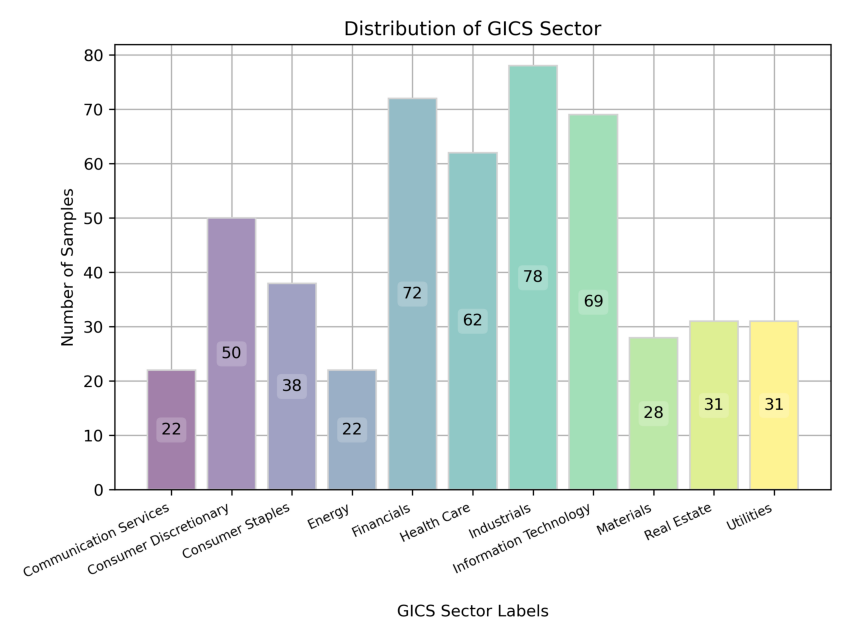

In [10]:
# Plot the Distribution for the GICS Sectors of all the Companies
plotFeatureDistribution(df=sp500Stocks, classFeature='GICS Sector', forceCategorical=False, pathsConfig=pathsConfig, featureDecoder=None)

In [11]:
# Extract a S&P-500 Stock Market Information
sp500MarketHistory = getSP500StockMarketInformation(config=config, pathsConfig=pathsConfig)

# Inpect the DataFrame
sp500MarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,0.016043
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,0.003116
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,0.000546
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,0.004001
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,0.002882


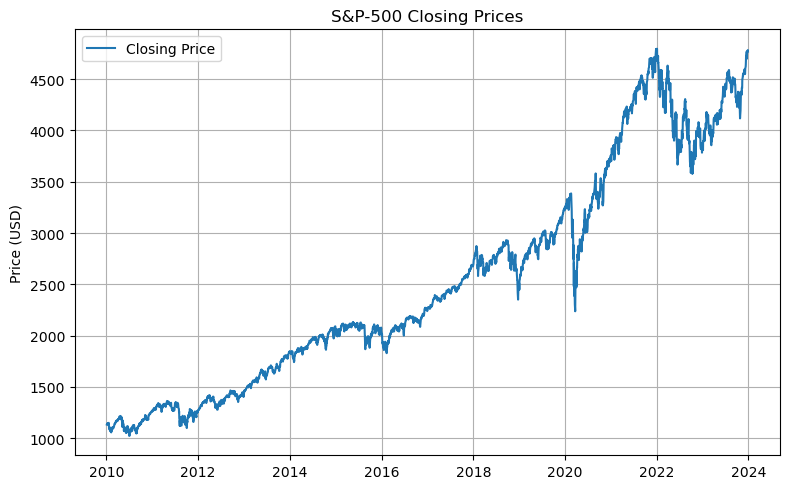

In [12]:
# Let's see a historical view of the closing price
plotStockClosingPrice(stockMarketHistory=sp500MarketHistory, title='S&P-500 Closing Prices')

---
### Feature Extraction and Creation
---

> ADD CONTENT TO HOW THE FEATURE EXTRACTION WAS PERFORMED WITH HELP OF THE YFINANCE APi

> MENTION ALL THE NEW METRICS CREATED TO BETTER DETERMINE THE VOLATILITY OF A STOCK

In [13]:
# EXAMPLE ON HOW TO EXTRACT A STOCK'S MARKET INFORMATION INTO A DATAFRAME

# Extract a Stock's Market Information
stockMarketHistory = getStockMarketInformation(stockSymbol='NVDA', config=config, pathsConfig=pathsConfig)
stockMarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,EMA,UpperBB,LowerBB,Daily Return,Cumulative Return,Covariance,Beta
0,2010-01-04,0.424410,0.426933,0.415239,0.423952,800204000,0.0,0.0,0.386383,0.388421,0.448434,0.324333,-0.010171,1.324499,0.000134,1.381324
1,2010-01-05,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0,0.391542,0.392395,0.449835,0.333250,0.014603,1.343840,0.000134,1.391764
2,2010-01-06,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0,0.394741,0.396252,0.454801,0.334681,0.006397,1.352436,0.000134,1.391018
3,2010-01-07,0.430601,0.432436,0.421200,0.424410,547792000,0.0,0.0,0.398409,0.398934,0.456148,0.340670,-0.019598,1.325932,0.000133,1.385144
4,2010-01-08,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0,0.401688,0.401447,0.457603,0.345773,0.002161,1.328797,0.000133,1.380440


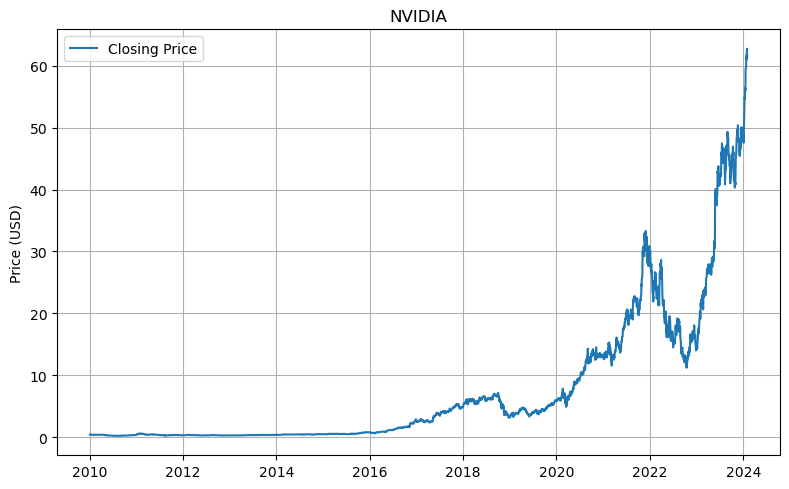

In [14]:
# Plotting the NVIDIA Closing Prices over the years
plotStockClosingPrice(stockMarketHistory=stockMarketHistory, title='NVIDIA')

In [16]:
stockMarketHistory.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,EMA,UpperBB,LowerBB,Daily Return,Cumulative Return,Covariance,Beta
0,2010-01-04,0.424410,0.426933,0.415239,0.423952,800204000,0.0,0.0,0.386383,0.388421,0.448434,0.324333,-0.010171,1.324499,0.000134,1.381324
1,2010-01-05,0.422347,0.434728,0.422347,0.430143,728648000,0.0,0.0,0.391542,0.392395,0.449835,0.333250,0.014603,1.343840,0.000134,1.391764
2,2010-01-06,0.429913,0.433811,0.425786,0.432894,649168000,0.0,0.0,0.394741,0.396252,0.454801,0.334681,0.006397,1.352436,0.000134,1.391018
3,2010-01-07,0.430601,0.432436,0.421200,0.424410,547792000,0.0,0.0,0.398409,0.398934,0.456148,0.340670,-0.019598,1.325932,0.000133,1.385144
4,2010-01-08,0.420971,0.428308,0.418449,0.425328,478168000,0.0,0.0,0.401688,0.401447,0.457603,0.345773,0.002161,1.328797,0.000133,1.380440


In [97]:
ds = stockPriceManager(stockSymbol='NVDA', feature='Close', windowSize=200, predictionDate='2024-01-01', pathsConfig=pathsConfig)
x_train, y_train, x_val, y_val, x_test, y_test = ds.trainTestSplit()
# x_train.shape, y_train.shape
# x_val.shape, y_val.shape
# x_test.shape, y_test.shape

In [98]:
ds.df.head()

,Train_0,Train_1,Train_2,Train_3,Train_4,Train_5,Train_6,Train_7,Train_8,Train_9,...,Train_191,Train_192,Train_193,Train_194,Train_195,Train_196,Train_197,Train_198,Target,Target_Date
0,0.004390,0.004514,0.004568,0.004399,0.004418,0.004299,0.004016,0.004125,0.003997,0.003760,...,0.000868,0.000831,0.000905,0.000882,0.000978,0.001124,0.001042,0.001101,0.001133,2010-10-19
1,0.004514,0.004568,0.004399,0.004418,0.004299,0.004016,0.004125,0.003997,0.003760,0.003906,...,0.000831,0.000905,0.000882,0.000978,0.001124,0.001042,0.001101,0.001133,0.001101,2010-10-20
2,0.004568,0.004399,0.004418,0.004299,0.004016,0.004125,0.003997,0.003760,0.003906,0.003874,...,0.000905,0.000882,0.000978,0.001124,0.001042,0.001101,0.001133,0.001101,0.001101,2010-10-21
3,0.004399,0.004418,0.004299,0.004016,0.004125,0.003997,0.003760,0.003906,0.003874,0.003732,...,0.000882,0.000978,0.001124,0.001042,0.001101,0.001133,0.001101,0.001101,0.001010,2010-10-22
4,0.004418,0.004299,0.004016,0.004125,0.003997,0.003760,0.003906,0.003874,0.003732,0.003463,...,0.000978,0.001124,0.001042,0.001101,0.001133,0.001101,0.001101,0.001010,0.001334,2010-10-25


In [68]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error'])

# early_stopping = EarlyStopping(
#     monitor='val_accuracy',
#     min_delta=5e-4,
#     patience=10,
#     restore_best_weights=True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,
#     patience=10,
#     min_lr=1e-5
# )

# Check the model architecture
model.summary()

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 13, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


NameError: name 'x_val' is not defined

In [ ]:
# !pip install scikeras[tensorflow]

In [20]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

def create_model(learning_rate=0.001, units=50):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=1)

param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)


Epoch 1/30
133/133 [==============================] - 5s 11ms/step - loss: 0.1360
Epoch 2/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0160
Epoch 3/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0139
Epoch 4/30
133/133 [==============================] - 1s 9ms/step - loss: 0.0190
Epoch 5/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0182
Epoch 6/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0115
Epoch 7/30
133/133 [==============================] - 1s 11ms/step - loss: 0.0119
Epoch 8/30
133/133 [==============================] - 1s 9ms/step - loss: 0.0141
Epoch 9/30
133/133 [==============================] - 1s 9ms/step - loss: 0.0118
Epoch 10/30
133/133 [==============================] - 1s 9ms/step - loss: 0.0098
Epoch 11/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0081
Epoch 12/30
133/133 [==============================] - 1s 9ms/step - loss: 0.0097
Epoch 13/30
133/13

In [28]:
grid_result.best_estimator_.get_params()
# grid_result.best_estimator_.model

{'verbose': 1,
 'batch_size': 16,
 'epochs': 30,
 'learning_rate': 0.001,
 'build_fn': <function __main__.create_model(learning_rate=0.001, units=50)>}

In [22]:
best_model = grid_result.best_estimator_.model
best_model.fit(x_train, y_train, batch_size=grid_result.best_params_['batch_size'],
               epochs=grid_result.best_params_['epochs'], verbose=1)

Epoch 1/30
133/133 [==============================] - 1s 11ms/step - loss: 0.0061
Epoch 2/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0060
Epoch 3/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0064
Epoch 4/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0064
Epoch 5/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0081
Epoch 6/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0053
Epoch 7/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0067
Epoch 8/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0075
Epoch 9/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0061
Epoch 10/30
133/133 [==============================] - 2s 12ms/step - loss: 0.0065
Epoch 11/30
133/133 [==============================] - 2s 12ms/step - loss: 0.0062
Epoch 12/30
133/133 [==============================] - 1s 10ms/step - loss: 0.0056
Epoch 13/30
1

In [ ]:
# Extract the market informations for all stocks
# for symbol in sp500Stocks.Symbol:
#     X = getStockMarketInformation(stockSymbol=symbol, config=config, pathsConfig=pathsConfig)
#     if X is None:
#         print("Failed", symbolC
#         break
#     else:
#         print(f"Processed {symbol}")

---

<div align="center">

## ADD OTHER SECTIONS - PORTFOLIO OPTIMIZATION PROGRAM
</div>

---

<div align="center">
    
---
## Conclusions
---
</div>

> ADD CONCLUSIONS

<div align="center">

---
## Bibliographic References
---
</div>

1. AUTHOR (YEAR). __*TITLE*__. Available [here](_LINK_)

LINKS:
- https://medium.com/@kasperjuunge/yfinance-10-ways-to-analyze-stock-prices-18d2062ab35c

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=M2fOqMOebz5GcYoj)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Francisco Macieira](https://github.com/franciscovmacieira) &#8594; `up202207166@edu.fc.up.pt`
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@edu.fc.up.pt`

---
---
## TESTS

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load your stock closing prices
data = pd.read_csv(pathsConfig["Datasets"]["Stocks-Market-Information"]+f"/NVDA.csv")  # Replace with your data source
closing_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(closing_prices)

In [29]:
initial_train_size = 200
horizon = 1  # Predicting 1 day ahead
window_size = 30  # Number of past days used for predictions
step_size = 20  # Move forward by 1 day each iteration


In [30]:
def create_sequences(X, window_size):
    sequences = []
    for i in range(len(X) - window_size):
        sequences.append(X[i:i + window_size])
    return np.array(sequences)


In [31]:
n_iterations = (len(data_scaled) - initial_train_size - horizon) // step_size
predictions = []
true_values = []


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

for i in range(n_iterations):
    # Define training and test indices
    train_end = initial_train_size + i * step_size
    test_end = train_end + horizon

    # Split data into training and test sets
    X_train = data_scaled[:train_end]
    y_test = data_scaled[train_end:test_end]

    # Create sequences for training
    X_train_seq = create_sequences(X_train, window_size)
    y_train_seq = X_train[window_size:]

    # Reshape for LSTM input
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))

    # Build the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(window_size, 1)),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train the model
    model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)

    # Prepare input for prediction
    X_input = X_train[-window_size:].reshape((1, window_size, 1))

    # Make prediction
    y_pred = model.predict(X_input)

    # Store prediction and true value
    predictions.append(y_pred[0, 0])
    true_values.append(y_test[0, 0])


1/1 [==============================] - 0s 149ms/step


In [33]:
# Convert lists to arrays
predictions = np.array(predictions).reshape(-1, 1)
true_values = np.array(true_values).reshape(-1, 1)

# Inverse transform the predictions and true values
predictions_inv = scaler.inverse_transform(predictions)
true_values_inv = scaler.inverse_transform(true_values)


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_values_inv, predictions_inv)
mae = mean_absolute_error(true_values_inv, predictions_inv)

print(f"Rolling Forecast MSE: {mse}")
print(f"Rolling Forecast MAE: {mae}")


Rolling Forecast MSE: 0.28833114311835784
Rolling Forecast MAE: 0.2695995833345516


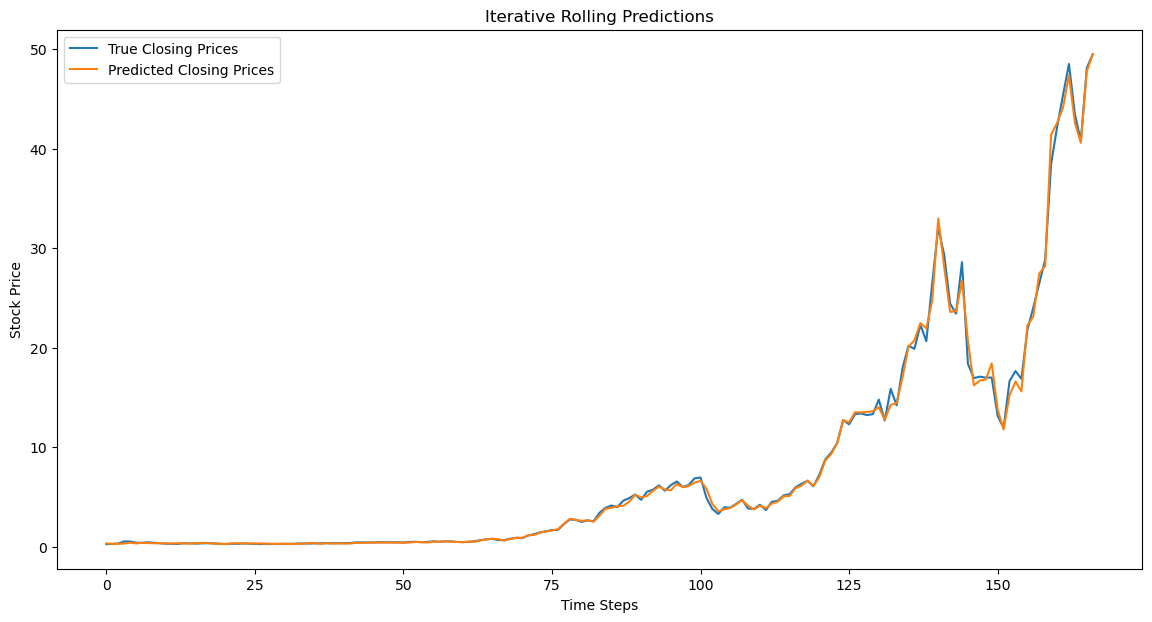

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(range(len(predictions_inv)), true_values_inv, label='True Closing Prices')
plt.plot(range(len(predictions_inv)), predictions_inv, label='Predicted Closing Prices')
plt.title('Iterative Rolling Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
